#1 Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomCrop, RandomZoom, RandomContrast


# 1.1 Create the Dataset and Split it into Training and Validation Sets


In [2]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = "D:\\University\\ArchitectureStyles\\archive\\architectural-styles-dataset"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             label_mode='categorical',
                                             subset='training',

                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             label_mode='categorical',
                                             seed=42)

Found 10112 files belonging to 25 classes.
Using 8090 files for training.
Found 10112 files belonging to 25 classes.
Using 2022 files for validation.


Represent data

In [3]:
class_names = train_dataset.class_names
print(len(class_names))
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# 2 Preprocess and Augment Training Data

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [5]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential([])
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    data_augmentation.add(RandomZoom(0.2))
    data_augmentation.add(RandomCrop(height=IMG_SIZE[0], width=IMG_SIZE[1]))
    data_augmentation.add(RandomContrast(factor=0.2))
    return data_augmentation

Augumented images

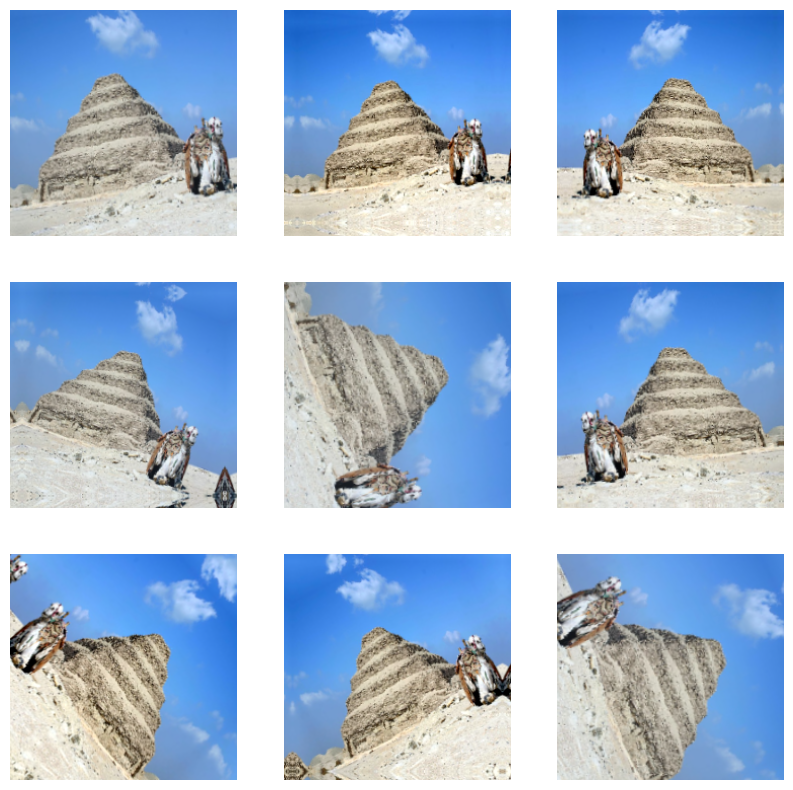

In [6]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

# 3 Using MobileNetV2

In [7]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [8]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

(32, 1000)


In [9]:
def arc_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    input_shape = image_shape + (3,)
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')
    base_model.trainable = False
    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(x)

    x = base_model(x, training=False)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024,activation='relu')(x)
    x = tf.keras.layers.Dense(1024,activation='relu')(x) 
    x = tf.keras.layers.Dense(512,activation='relu')(x)
    # x = tf.keras.layers.Dropout(0.2)(x)

    outputs = tf.keras.layers.Dense(25, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)

    return model

In [10]:
model2 = arc_model(IMG_SIZE, data_augmentation)
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
initial_epochs = 10
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/10


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(



253/253 [==============================] - 228s 861ms/step - loss: 2.0882 - accuracy: 0.3504 - val_loss: 1.6558 - val_accuracy: 0.4590
Epoch 2/10
253/253 [==============================] - 217s 854ms/step - loss: 1.6949 - accuracy: 0.4646 - val_loss: 1.5648 - val_accuracy: 0.4857
Epoch 3/10
253/253 [==============================] - 221s 870ms/step - loss: 1.5537 - accuracy: 0.5073 - val_loss: 1.5560 - val_accuracy: 0.4827
Epoch 4/10
253/253 [==============================] - 217s 855ms/step - loss: 1.4989 - accuracy: 0.5272 - val_loss: 1.5129 - val_accuracy: 0.5025
Epoch 5/10
253/253 [==============================] - 217s 854ms/step - loss: 1.4167 - accuracy: 0.5423 - val_loss: 1.5072 - val_accuracy: 0.5138
Epoch 6/10
253/253 [==============================] - 217s 855ms/step - loss: 1.3669 - accuracy: 0.5581 - val_loss: 1.4270 - val_accuracy: 0.5564
Epoch 7/10
253/253 [==============================] - 221s 870ms/step - loss: 1.2827 - accuracy: 0.5870 - val_loss: 1.5398 - val_accura

Results

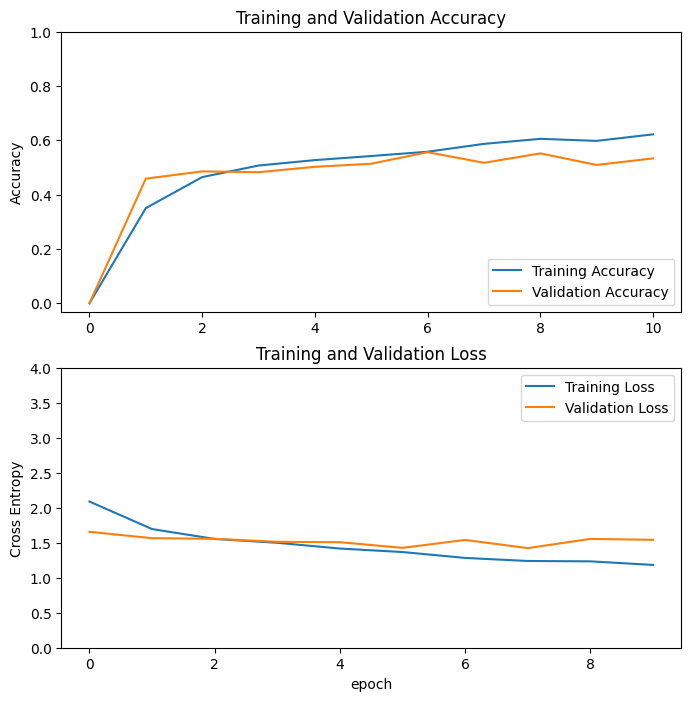

In [11]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [12]:
base_model = model2.layers[4]
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 120
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

loss_function=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1 * base_learning_rate)
# Use accuracy as evaluation metric
metrics=['accuracy']

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Number of layers in the base model:  154
Epoch 10/20
253/253 [==============================] - 274s 1s/step - loss: 1.3424 - accuracy: 0.5742 - val_loss: 1.6550 - val_accuracy: 0.4916
Epoch 11/20
253/253 [==============================] - 258s 1s/step - loss: 1.1624 - accuracy: 0.6302 - val_loss: 1.4440 - val_accuracy: 0.5643
Epoch 12/20
253/253 [==============================] - 261s 1s/step - loss: 1.0485 - accuracy: 0.6587 - val_loss: 1.4096 - val_accuracy: 0.5678
Epoch 13/20
253/253 [==============================] - 256s 1s/step - loss: 0.9890 - accuracy: 0.6735 - val_loss: 1.2955 - val_accuracy: 0.5979
Epoch 14/20
253/253 [==============================] - 256s 1s/step - loss: 0.9123 - accuracy: 0.6981 - val_loss: 1.2965 - val_accuracy: 0.6019
Epoch 15/20
253/253 [==============================] - 255s 1s/step - loss: 0.8457 - accuracy: 0.7142 - val_loss: 1.4955 - val_accuracy: 0.6014
Epoch 16/20
253/253 [==============================] - 255s 1s/step - loss: 0.8438 - accuracy: 

Results

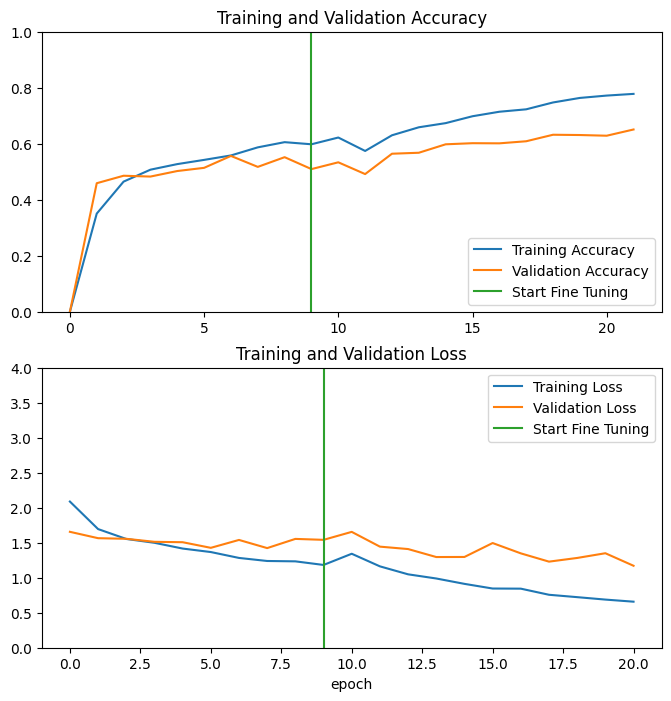

In [13]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 4.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Save the model


In [14]:
model_name = "tf_architecture_keras_mobilenetv2.v2"
model2.save(f"models/{model_name}.h5")

In [15]:
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('models/arcitecv2.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Temp\tmpmjsc6qpz\assets


INFO:tensorflow:Assets written to: C:\Temp\tmpmjsc6qpz\assets
